## Simmulated annealing para planificación de trayectorias aéreas

- Catalina Lizana Guzmán

- Fabián C. Ulloa

### Contexto e Implementación

La idea de este proyecto es estudiar el uso de Simulated Annealing en la simulación de las trayectorias de aviones, con el fin de optimizar su recorrido en términos de horario y/o evitar choques entre ellos. Para ello se tomará el modelo presentado en la sección "Large-Scale 4D Trajectory Planning" del libro "Air Traffic Management and Systems II" [1]. Para efectos de nuestro proyecto se elegirán valores apropiados para los diversos parámetros asociados y se realizaran algunas simplificaciones del problema, esto pues, el caso real es de una complejidad computacional mayor.


Consideramos un espacio de 2 dimensiones de $200\times 200 $ (en kilometros) y un intervalo de tiempo (de despegue) de 60 (minutos), en primera instancia ubicamos un aeropuerto de salida en las coordenadas (0,0) y un aeropuerto de llegada en el punto (200,200), cada avión tiene una velocidad de 200 km/h (aprox. el promedio para aviones comerciales) y una trayectoria asociada que consiste en una lista de $n$ coordenadas que conecta ambos aeropuertos, cada una de estas coordenadas será de la forma $(x,y,t) \in [0,200]^2 \times [0,\infty]$, donde (x,y) corresponde a las coordenadas espaciales y $t$ corresponde al tiempo.

Por otro lado las trayectorias tienen "interacciones", una interacción sucede cuando 2 aviones están lo suficientemente cerca en un punto en un intervalo de tiempo. Para ser más preciso, diremos que 2 puntos están cerca en el espacio si la distancia de sus coordenadas espaciales es menor a $1.7$, y están cerca en el tiempo si la distancia de las coordenadas temporales es menor a $0.5$ (es decir $30$ segundos).

Para implementar el algoritmo SA creamos trayectorias con las cuales trabajar: Para obtener los puntos intermedios consideramos puntos "al azar por cuadrantes", esto es, por ejemplo si queremos crear una trayectoria de $20$ puntos (intermedios), consideramos los 20 cuadrantes: $[0,10]\times[0,10], [10,20]\times[10,20],..., [190,200]\times[190,200]$, entonces para obtener el primer punto se elige uno al azar en el primer cuadrante $[0,10]\times[0,10]$, el segundo punto es elegido al azar en el segundo cuadrante $[10,20]\times[10,20]$ y así sucesivamente, mientras que la coordenada temporal, para el punto inicial $(0,0,t_0)$, $t_0$ es elegido de forma aleatoria en $(0,60)$ y para el resto de puntos el tiempo es calculado según la velocidad. Notar que con esto creamos trayectorias tales que lleguen al destino final y que sigan una ruta (se podría haber complejizado más la forma de la ruta pero no es lo principal del trabajo) y que el tiempo entre coordenadas sea el apropiado.

Para detectar las interacciones discretizamos el espacio y el tiempo formando una grilla, de esta manera obtenemos celdas (que representan la grilla), se itera sobre cada punto sobre cada trayectoria, cada punto se guarda es la celda que corresponda y se chequean las celdas adyacetes a ella, de existir otro punto en una de estas celdas se verifica si hay interacción o no entre estos puntos. Si bien este "algoritmo" puede ser un poco engorroso es mucho más eficiente que verificar la interacción de puntos de a pares.

Como el objetivo es minimizar las interacciones, éstas serán la "energía" a minimizar del algoritmo SA. Para definir el grafo con el cual trabajar, decimos que dos trayectorias son "vecinas" si difieren en un punto espacial de una trayectoria, para efectos de esta implementación, un vecino se creará a partir de una trayectoria considerada, cambiando un punto al azar, moviendolo (también al azar) una distancia de a lo más $\frac{1.7} {\sqrt{2}}$ en ambas direcciones espaciales $x,y$, de esta manera, la trayectoria no cambia de forma abrupta pero se cambia lo suficiente como para que las interacciones puedan cambiar.

Se procede a trabajar con distintos $\beta_n$ (exponencial, lineal, polinómico y logaritmico) sobre $20$ trayectorias de $50$ puntos (sin contar el inicial ni el final) y se corre el algoritmo considerando cadenas de largo $25k, \ k=1,2,...20$, además se miden los tiempos de ejecución.


[1] Arianit Islami, Supatcha Chaimatanan, Daniel Delahaye. Large Scale 4D Trajectory Planning. Air Traffic Management and Systems – II , 420, Springer, pp 27-47, 2016, Lecture Notes in Electrical Engineering


In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from matplotlib import animation

X = Y = 200 
T = 60
# 200 km/h es la vel de un avión comercial aprox.
vel = 10 / 3

def crear_trayectoria(n_tray,n_puntos):
    trayectories = []
    delta = X / n_puntos

    for i in range(n_tray):
        P = []
        x = 0
        y = 0
        t = np.random.randint(0, T)
        P.append([x, y, t]) 

        for k in range(n_puntos):
            x = np.random.uniform(delta*k, delta*(k+1))
            y = np.random.uniform(delta*k, delta*(k+1))
            # Calcular t = dist/ vel
            a = np.array((x, y))
            b = np.array((P[k][0], P[k][1]))
            dist = np.linalg.norm(a-b)
            t = dist / vel + P[k][2]
            P.append([x, y, t])
        
        a = np.array((X, Y))
        b = np.array((P[n_puntos][0], P[n_puntos][1]))
        dist = np.linalg.norm(a-b)
        t = dist / vel + P[n_puntos][2]
        P.append([X, Y, t])
        P = np.array(P)
        trayectories.append(P)
    return trayectories

In [2]:
# Constantes a usar en el cálculo de la interacción.
d_x = d_y = int(X / 100)
d_t = 1
N_x = int(X / d_x)
N_y = int(Y / d_y)
N_t = int(T / d_t)
# A la velocidad que van, en 30 segundos avanzan 5/3 [km].
N_h = 1.7
d_vec = 1.7 / np.sqrt(2)
t_eps = 1 / 2 

In [3]:
# Funciones para calcular la iteración.
def C(P, Q):
    """ Determina si los puntos P y Q están interactuando"""
    x = P[0] - Q[0]
    y = P[1] - Q[1]
    d_h = np.linalg.norm((x, y))       #Distancia 
    if np.abs(P[2] - Q[2]) < t_eps and d_h <= N_h:
        return 1
    else:
        return 0


def interaccion(tray, i, k):
    """ Calcula cuántos puntos interactuan en el punto k de la trayectoria i """
    suma = 0
    N=len(tray)
    for j in range(N):
        if j>i:
            for l in range(1,len(tray[j])-1):
                suma += C(tray[i][k], tray[j][l])  
    return suma


def Interacciones(trayectorias):
    """ Calcula el total de puntos interactuando dada una distribución de trayectorias"""
    phi = 0
    N = len(trayectorias)
    for i in range(N):
        for k in range(i, len(trayectorias[i])-1):
            phi += interaccion(trayectorias, i, k)    
    return phi
  

# El siguiente algoritmo para calcular lo anterior es más eficiente.
def interaccion_por_grilla(tray):
    cas_x = []
    cas_y = []
    cas_t = []

    # Creamos más casillas de las "necesarias" con tal de que no exista
    # error al momento de hacer la iteración.
    for x in range(N_x + 10):
        cas_x.append([])
    for y in range(N_y + 10):
        cas_y.append([])
    # A priori debiesemos calcular el máximo tiempo en la trayectoria, pero la cota 3*N_t es lo suficientemente grande.
    for t in range(3 * N_t):
        cas_t.append([])
         
    phi = 0
    
    for t in tray:
        for P in t[1:-1]:
            n_x = int(P[0] / d_x)
            n_y = int(P[1] / d_y)
            n_t = int(P[2] / d_t)
            
            # Veo si en las casillas adjuntas hay algún punto cerca.
            for i in range(-1, 2):
                for j in range(-1, 2):
                    for k in range(-1, 2):
                        if len(cas_x[n_x + i])>0 and len(cas_y[n_y + j])>0 and len(cas_t[n_t + k])>0:
                            for Q in cas_x[n_x + i]:
                                if (Q in cas_y[n_y + j]) and (Q in cas_t[n_t + k]):
                                    phi += C(P,Q)

            cas_x[n_x].append(list(P))
            cas_y[n_y].append(list(P))
            cas_t[n_t].append(list(P))
    
    return phi

In [4]:
# Funciones para crear un vecino

def cambio_tiempos(T,i):
    """ Dado una trayectoria T con un punto i cambiado, se calculan los cambios en los tiempos"""
    T1 = T.copy()
    tiempo = T1[i-1][2]

    for k in range(i,len(T)):
        a=T1[k-1][0:2]
        b=T1[k][0:2]
        dist = np.linalg.norm(a-b)
        T1[k][2] = dist / vel + tiempo
        tiempo=T1[k][2]
    return T1

def neighborhood(trayectorias):
    t = trayectorias.copy()
    new_1 = new_2 = -1
    while new_1 > X or 0 > new_1 or new_2 > Y or 0 > new_2 :
        i = np.random.randint(0, len(trayectorias))
        new_t = t[i]
        j = np.random.randint(1, len(new_t)-1)
        new_1 = new_t[j][0] + np.random.uniform(-d_vec, d_vec)
        new_2 = new_t[j][1] + np.random.uniform(-d_vec, d_vec)
    
    
    new_t[j][0] = new_1
    new_t[j][1] = new_2
    cambio_tiempos(new_t,j)
    t[i] = cambio_tiempos(new_t,j)
    return t

In [5]:
# Sucesiones beta a utilizar

# beta_n polinomico
def beta_cuad(n):
    return n ** (2)

# beta_n exponencial
def beta_exp(n):
    return 3 ** n

# beta_n lineal
def beta_lin(n):
    return 2 * n

In [6]:
# Algoritmo SA

def CM(t, func_beta, trayectorias):
    """
    Simula la cadena hasta tiempo t
    func_beta es la función que da el valor de beta
    según cada iteración
    """
    X = []
    X.append(trayectorias) 
    u = np.random.uniform(0,1,t)
    
    for n in range(t):
        beta = func_beta(n)
        Y = neighborhood(X[n])
        cte_n = np.min((1, np.exp(float(-beta * (interaccion_por_grilla(Y) - interaccion_por_grilla(X[n]))))))
        
        if u[n] < cte_n:
            X.append(Y)
        else:
            X.append(X[n])
            
    return X

In [7]:
# Calcular el tiempo de ejecución.
def timeSince(since):
    now = time.time_ns()
    s = now - since
    return s * 10**(-9)

In [8]:
# Parámetros a cambiar.
n_tray = 20 # n_tray entero entre 0 y 20 (trayectorias)
n_puntos = 30 # n_puntos entero mayor o igual a 1

trayectorias = crear_trayectoria(n_tray, n_puntos)

MovieWriter ffmpeg unavailable; using Pillow instead.


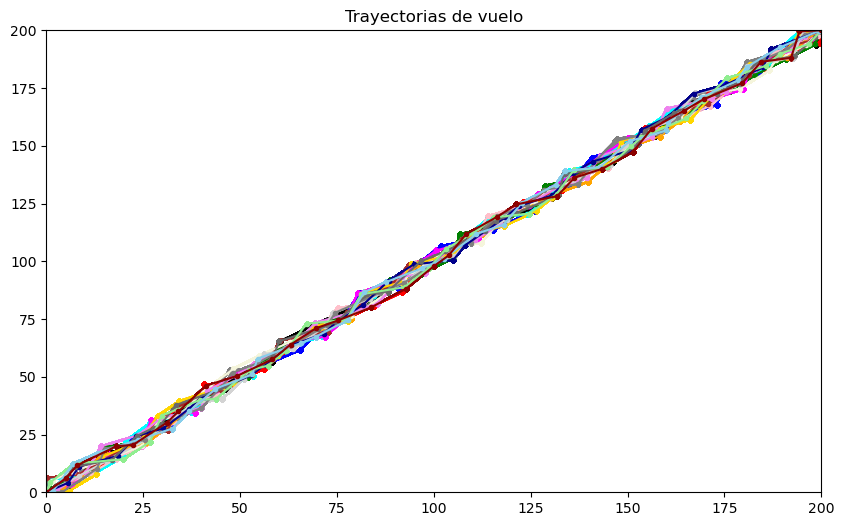

In [9]:
# Grafico las trayectorias a usar
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["black", "blue", "grey", "red", "cyan", "green", "magenta", "pink", "orange", "brown", "beige",
          "gold", "violet", "lightgrey", "grey", "darkblue", "dimgrey", "lightgreen", "skyblue", "darkred"]
tmax = 0

for P in trayectorias:
    tmax = max(max(P[:,2]), tmax)

def update_anim(t):
    for j in range(len(trayectorias)):
        P = trayectorias[j]
        puntos = np.array([p for p in P if p[2]<=t])
        color_ = colors[j]
        
        if len(puntos)>0:
            ax.plot(puntos[:,0], puntos[:,1], ".-", color = color_)
            plt.xlim(0, 200)
            plt.ylim(0, 200)
            plt.title("Trayectorias de vuelo")
        
num_frames = int(tmax + 2)
anim = animation.FuncAnimation(fig, update_anim, frames = np.linspace(0, num_frames, num_frames))
anim.save('trays_.gif', writer='ffmpeg')

In [10]:
# Parámetros a cambiar.
fn_beta = beta_cuad # Cambiar por beta_cuad, beta_exp, beta_lin

# Guardaremos los tiempos de ejecucion
t_e_beta = [0]

# Se considerarán cadenas de tamaño 25k con k=1,...,15
tiempos = np.linspace(0, 500, 21)  
tiempos = tiempos.astype(int)  

# Guardaremos los valores de Interacciones
Is_beta = np.zeros(len(tiempos))

I_inic = interaccion_por_grilla(trayectorias)

Is_beta[0] = I_inic

for i in range(1, len(tiempos)):
    start= time.time_ns()
    X_beta = CM(tiempos[i], fn_beta, trayectorias)
    t_e_beta.append(timeSince(start))
    Is_beta[i] = interaccion_por_grilla(X_beta[-1])

C:\Users\nico_\AppData\Local\Temp\ipykernel_10604\3401157527.py:16: RuntimeWarning: overflow encountered in exp
  cte_n = np.min((1, np.exp(float(-beta * (interaccion_por_grilla(Y) - interaccion_por_grilla(X[n]))))))


MovieWriter ffmpeg unavailable; using Pillow instead.


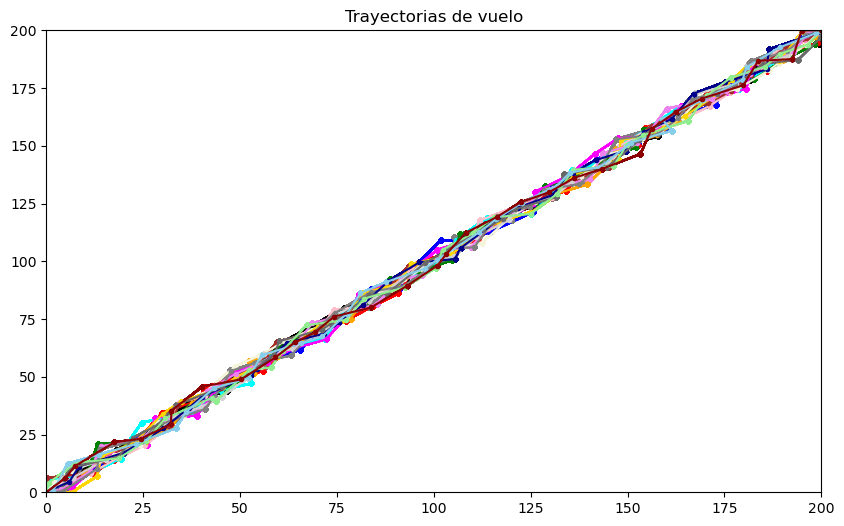

In [11]:
# Gráfico las trayectorias obtenidas despues de 500 iteraciones con fn_beta
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["black", "blue", "grey", "red", "cyan", "green", "magenta", "pink", "orange", "brown", "beige",
          "gold", "violet", "lightgrey", "grey", "darkblue", "dimgrey", "lightgreen", "skyblue", "darkred"]
tmax = 0
for P in X_beta[-1]:
    tmax = max(max(P[:,2]), tmax)

def update_anim(t):
    for j in range(len(X_beta[-1])):
        P = X_beta[-1][j]
        puntos = np.array([p for p in P if p[2]<=t])
        color_ = colors[j]
        
        if len(puntos)>0:
            ax.plot(puntos[:,0], puntos[:,1], ".-", color = color_)
            plt.xlim(0, 200)
            plt.ylim(0, 200)
            plt.title("Trayectorias de vuelo")
        
num_frames = int(tmax + 2)
anim = animation.FuncAnimation(fig, update_anim, frames = np.linspace(0, num_frames, num_frames))
anim.save('trays_SA.gif', writer='ffmpeg')

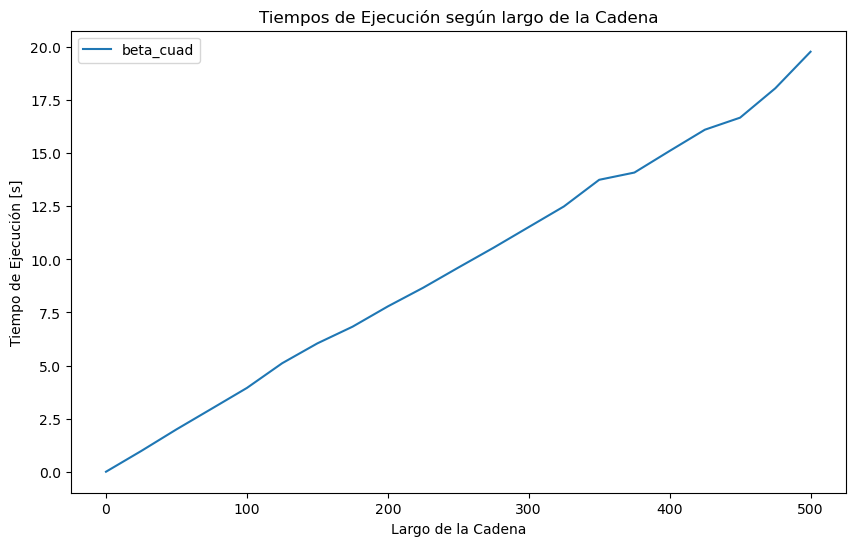

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(tiempos, t_e_beta, label=fn_beta.__name__)
plt.xlabel('Largo de la Cadena')
plt.ylabel('Tiempo de Ejecución [s]')
plt.title("Tiempos de Ejecución según largo de la Cadena")
plt.legend()
plt.show()

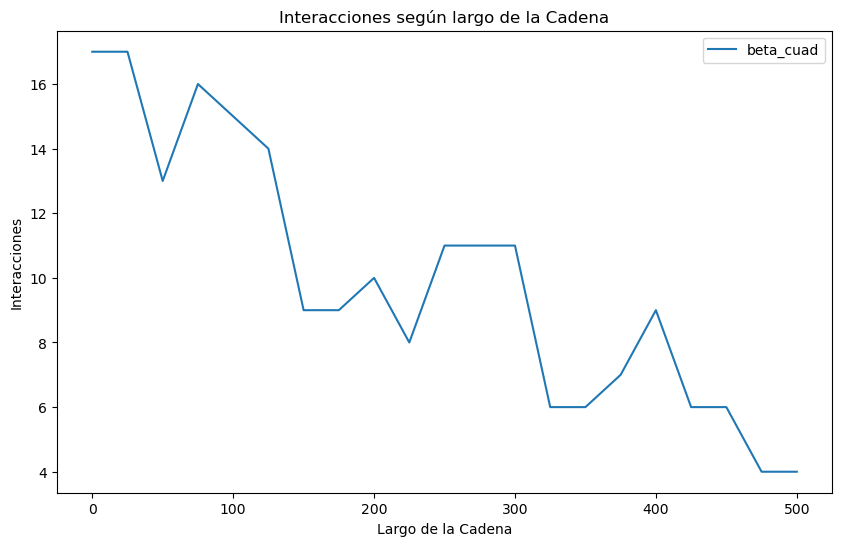

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(tiempos, Is_beta, label=fn_beta.__name__)
plt.xlabel('Largo de la Cadena')
plt.ylabel('Interacciones')
plt.title("Interacciones según largo de la Cadena")
plt.legend()
plt.show()

In [14]:
# Veamos los valores específicos.
print(Is_beta)

[17. 17. 13. 16. 15. 14.  9.  9. 10.  8. 11. 11. 11.  6.  6.  7.  9.  6.
  6.  4.  4.]
